In [18]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

from matplotlib.patches import Patch

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

In [19]:
# Utility functions for similarity analysis and visualization

def calculate_similarity_matrices(feature_matrix):
    """Calculate AND and XNOR similarity matrices."""
    n_langs = len(feature_matrix)
    n_features = len(feature_matrix.columns)
    
    and_matrix = np.zeros((n_langs, n_langs))
    xnor_matrix = np.zeros((n_langs, n_langs))
    
    for i in range(n_langs):
        for j in range(n_langs):
            if i == j:
                and_matrix[i, j] = feature_matrix.iloc[i].sum()
                xnor_matrix[i, j] = n_features
            else:
                shared_ones = ((feature_matrix.iloc[i] == 1) & (feature_matrix.iloc[j] == 1)).sum()
                and_matrix[i, j] = shared_ones
                
                both_zero = ((feature_matrix.iloc[i] == 0) & (feature_matrix.iloc[j] == 0)).sum()
                xnor_matrix[i, j] = both_zero + shared_ones
    
    return and_matrix, xnor_matrix, n_features

def visualize_similarity_matrices(and_matrix, xnor_matrix, lang_names, title_suffix="", figsize=(28, 12), use_proxy_labels=False):
    """Create side-by-side heatmaps of AND and XNOR similarity matrices."""
    n_langs = len(and_matrix)
    
    # Calculate average pairwise similarities
    upper_triangle_indices = np.triu_indices(n_langs, k=1)
    avg_and = and_matrix[upper_triangle_indices].mean()
    avg_xnor = xnor_matrix[upper_triangle_indices].mean()
    
    # Hierarchical clustering for ordering
    max_similarity = and_matrix.max()
    distance_matrix = max_similarity - and_matrix
    np.fill_diagonal(distance_matrix, 0)
    
    linkage_matrix = linkage(squareform(distance_matrix), method='average')
    dendro = dendrogram(linkage_matrix, no_plot=True)
    sorted_indices = dendro['leaves']
    
    # Reorder matrices
    and_sorted = and_matrix[sorted_indices, :][:, sorted_indices]
    xnor_sorted = xnor_matrix[sorted_indices, :][:, sorted_indices]
    
    # Create labels
    if use_proxy_labels:
        names_sorted = [f"Lang{i+1}" for i in range(n_langs)]
    else:
        names_sorted = [lang_names[i] for i in sorted_indices]
    
    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # AND similarity
    im1 = ax1.imshow(and_sorted, cmap='YlOrRd', aspect='auto')
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label('Shared 1s', rotation=270, labelpad=20)
    
    ax1.set_xticks(range(n_langs))
    ax1.set_yticks(range(n_langs))
    ax1.set_xticklabels(names_sorted, rotation=90, fontsize=12)
    ax1.set_yticklabels(names_sorted, fontsize=12)
    
    for i in range(n_langs):
        for j in range(n_langs):
            ax1.text(j, i, f'{int(and_sorted[i, j])}',
                    ha="center", va="center", color="black", fontsize=12)
    
    ax1.set_title(f'AND Similarity (Shared Features){title_suffix}\n(Average pairwise: {avg_and:.2f})', fontsize=14)
    
    # XNOR similarity
    im2 = ax2.imshow(xnor_sorted, cmap='YlGn', aspect='auto')
    cbar2 = plt.colorbar(im2, ax=ax2)
    cbar2.set_label('Total Agreement', rotation=270, labelpad=20)
    
    ax2.set_xticks(range(n_langs))
    ax2.set_yticks(range(n_langs))
    ax2.set_xticklabels(names_sorted, rotation=90, fontsize=12)
    ax2.set_yticklabels(names_sorted, fontsize=12)
    
    for i in range(n_langs):
        for j in range(n_langs):
            ax2.text(j, i, f'{int(xnor_sorted[i, j])}',
                    ha="center", va="center", color="black", fontsize=12)
    
    ax2.set_title(f'XNOR Similarity (Total Agreement){title_suffix}\n(Average pairwise: {avg_xnor:.2f})', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    n_features = int(xnor_matrix[0, 0])
    and_pairwise = and_matrix[upper_triangle_indices]
    xnor_pairwise = xnor_matrix[upper_triangle_indices]
    
    print(f"Total number of bits (features): {n_features}")
    print(f"\tAND Similarity (shared 1s):")
    print(f"\t\tAverage: {avg_and:.2f}, Min: {and_pairwise.min():.0f}, Max: {and_pairwise.max():.0f}")
    print(f"\tXNOR Similarity (total agreement):")
    print(f"\t\tAverage: {avg_xnor:.2f}, Min: {xnor_pairwise.min():.0f}, Max: {xnor_pairwise.max():.0f}")

def plot_similarity_distributions(and_matrix, xnor_matrix, title_suffix="", figsize=(16, 6)):
    """Plot histograms of AND and XNOR similarity distributions (normalized as fractions)."""
    n_langs = len(and_matrix)
    n_features = int(xnor_matrix[0, 0])
    
    # Get upper triangle (pairwise similarities, excluding diagonal)
    upper_triangle_indices = np.triu_indices(n_langs, k=1)
    and_pairwise = and_matrix[upper_triangle_indices] / n_features  # Normalize
    xnor_pairwise = xnor_matrix[upper_triangle_indices] / n_features  # Normalize
    
    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # AND similarity distribution
    ax1.hist(and_pairwise, bins=30, color='orangered', alpha=0.7, edgecolor='black')
    ax1.axvline(and_pairwise.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {and_pairwise.mean():.3f}')
    ax1.axvline(np.median(and_pairwise), color='darkred', linestyle=':', linewidth=2, label=f'Median: {np.median(and_pairwise):.3f}')
    ax1.set_xlabel('Fraction of Shared 1s', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.set_title(f'AND Similarity Distribution{title_suffix}\n({len(and_pairwise)} pairwise comparisons)', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # XNOR similarity distribution
    ax2.hist(xnor_pairwise, bins=30, color='green', alpha=0.7, edgecolor='black')
    ax2.axvline(xnor_pairwise.mean(), color='darkgreen', linestyle='--', linewidth=2, label=f'Mean: {xnor_pairwise.mean():.3f}')
    ax2.axvline(np.median(xnor_pairwise), color='darkgreen', linestyle=':', linewidth=2, label=f'Median: {np.median(xnor_pairwise):.3f}')
    ax2.set_xlabel('Fraction of Total Agreement', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title(f'XNOR Similarity Distribution{title_suffix}\n({len(xnor_pairwise)} pairwise comparisons)', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"AND Similarity Statistics (normalized):")
    print(f"\tMean: {and_pairwise.mean():.3f}, Median: {np.median(and_pairwise):.3f}")
    print(f"\tStd Dev: {and_pairwise.std():.3f}, Min: {and_pairwise.min():.3f}, Max: {and_pairwise.max():.3f}")
    print(f"\nXNOR Similarity Statistics (normalized):")
    print(f"\tMean: {xnor_pairwise.mean():.3f}, Median: {np.median(xnor_pairwise):.3f}")
    print(f"\tStd Dev: {xnor_pairwise.std():.3f}, Min: {xnor_pairwise.min():.3f}, Max: {xnor_pairwise.max():.3f}")
    print(f"\t(Based on {n_features} total features)")

def create_feature_heatmap(feature_matrix, lang_coords, color_map, title, figsize=(20, 12)):
    """Create a heatmap of features by language with custom coloring."""
    # Order languages by feature count
    language_feature_counts = feature_matrix.sum(axis=1).sort_values(ascending=False)
    ordered_languages = language_feature_counts.index
    lang_rank = {lang_id: i for i, lang_id in enumerate(ordered_languages)}
    
    # Order features by prevalence
    feature_counts = feature_matrix.sum(axis=0)
    feature_sort_keys = []
    for feat in feature_matrix.columns:
        count = feature_counts[feat]
        langs_with_feature = feature_matrix[feature_matrix[feat] == 1].index
        avg_lang_rank = sum(lang_rank[lang] for lang in langs_with_feature) / len(langs_with_feature) if len(langs_with_feature) > 0 else float('inf')
        feature_sort_keys.append((feat, count, avg_lang_rank))
    
    feature_sort_keys.sort(key=lambda x: (-x[1], x[2]))
    ordered_features = [x[0] for x in feature_sort_keys]
    
    # Reorder matrix
    feature_matrix_ordered = feature_matrix.loc[ordered_languages, ordered_features]
    
    # Create color array
    heatmap_data = np.zeros((len(feature_matrix_ordered), len(feature_matrix_ordered.columns), 4))
    
    for i, (lang_id, row) in enumerate(feature_matrix_ordered.iterrows()):
        lang_color = color_map[lang_id]
        for j, value in enumerate(row):
            heatmap_data[i, j] = lang_color if value == 1 else [1, 1, 1, 1]
    
    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(heatmap_data, aspect='auto', interpolation='nearest')
    
    ax.set_yticks(range(len(feature_matrix_ordered)))
    ax.set_yticklabels([f"{lang_coords[lang_coords['Language_ID'] == lang_id]['Name'].iloc[0]} ({int(language_feature_counts[lang_id])})" 
                         for lang_id in ordered_languages], fontsize=10)
    
    ax.set_xticks(range(len(feature_matrix_ordered.columns)))
    ax.set_xticklabels([f"{feat} ({int(feature_counts[feat])})" for feat in ordered_features], 
                        rotation=90, fontsize=6)
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Grammatical Features (Parameter IDs) - ordered by prevalence', fontsize=12)
    ax.set_ylabel('Languages (# of features)', fontsize=12)
    
    # Legend
    legend_elements = [Patch(facecolor=color_map[lang_id], 
                             label=f"{lang_coords[lang_coords['Language_ID'] == lang_id]['Name'].iloc[0]}")
                       for lang_id in ordered_languages]
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    plt.tight_layout()
    plt.show()

In [20]:
# Get the current working directory
print("Current working directory:", os.getcwd())

# Use absolute path
data_path = Path("/home/rizfn/github/babel-transition/src/dataAnalysis/grambank/data/cldf")

# Load the main tables into pandas DataFrames
languages_df = pd.read_csv(data_path / "languages.csv")
parameters_df = pd.read_csv(data_path / "parameters.csv") 
values_df = pd.read_csv(data_path / "values.csv")
codes_df = pd.read_csv(data_path / "codes.csv")

# Display basic info about the datasets
print("Languages table shape:", languages_df.shape)
print("Parameters table shape:", parameters_df.shape)
print("Values table shape:", values_df.shape)
print("Codes table shape:", codes_df.shape)

# Show first few rows
print("\nLanguages columns:", languages_df.columns.tolist())
print("Parameters columns:", parameters_df.columns.tolist())
print("Values columns:", values_df.columns.tolist())
print("Codes columns:", codes_df.columns.tolist())

Current working directory: /home/rizfn/github/babel-transition/src/dataAnalysis/grambank
Languages table shape: (2467, 13)
Parameters table shape: (195, 12)
Values table shape: (441663, 9)
Codes table shape: (398, 4)

Languages columns: ['ID', 'Name', 'Macroarea', 'Latitude', 'Longitude', 'Glottocode', 'ISO639P3code', 'provenance', 'Family_name', 'Family_level_ID', 'Language_level_ID', 'level', 'lineage']
Parameters columns: ['ID', 'Name', 'Description', 'ColumnSpec', 'Patrons', 'Grambank_ID_desc', 'Boundness', 'Flexivity', 'Gender_or_Noun_Class', 'Locus_of_Marking', 'Word_Order', 'Informativity']
Values columns: ['ID', 'Language_ID', 'Parameter_ID', 'Value', 'Code_ID', 'Comment', 'Source', 'Source_comment', 'Coders']
Codes columns: ['ID', 'Parameter_ID', 'Name', 'Description']


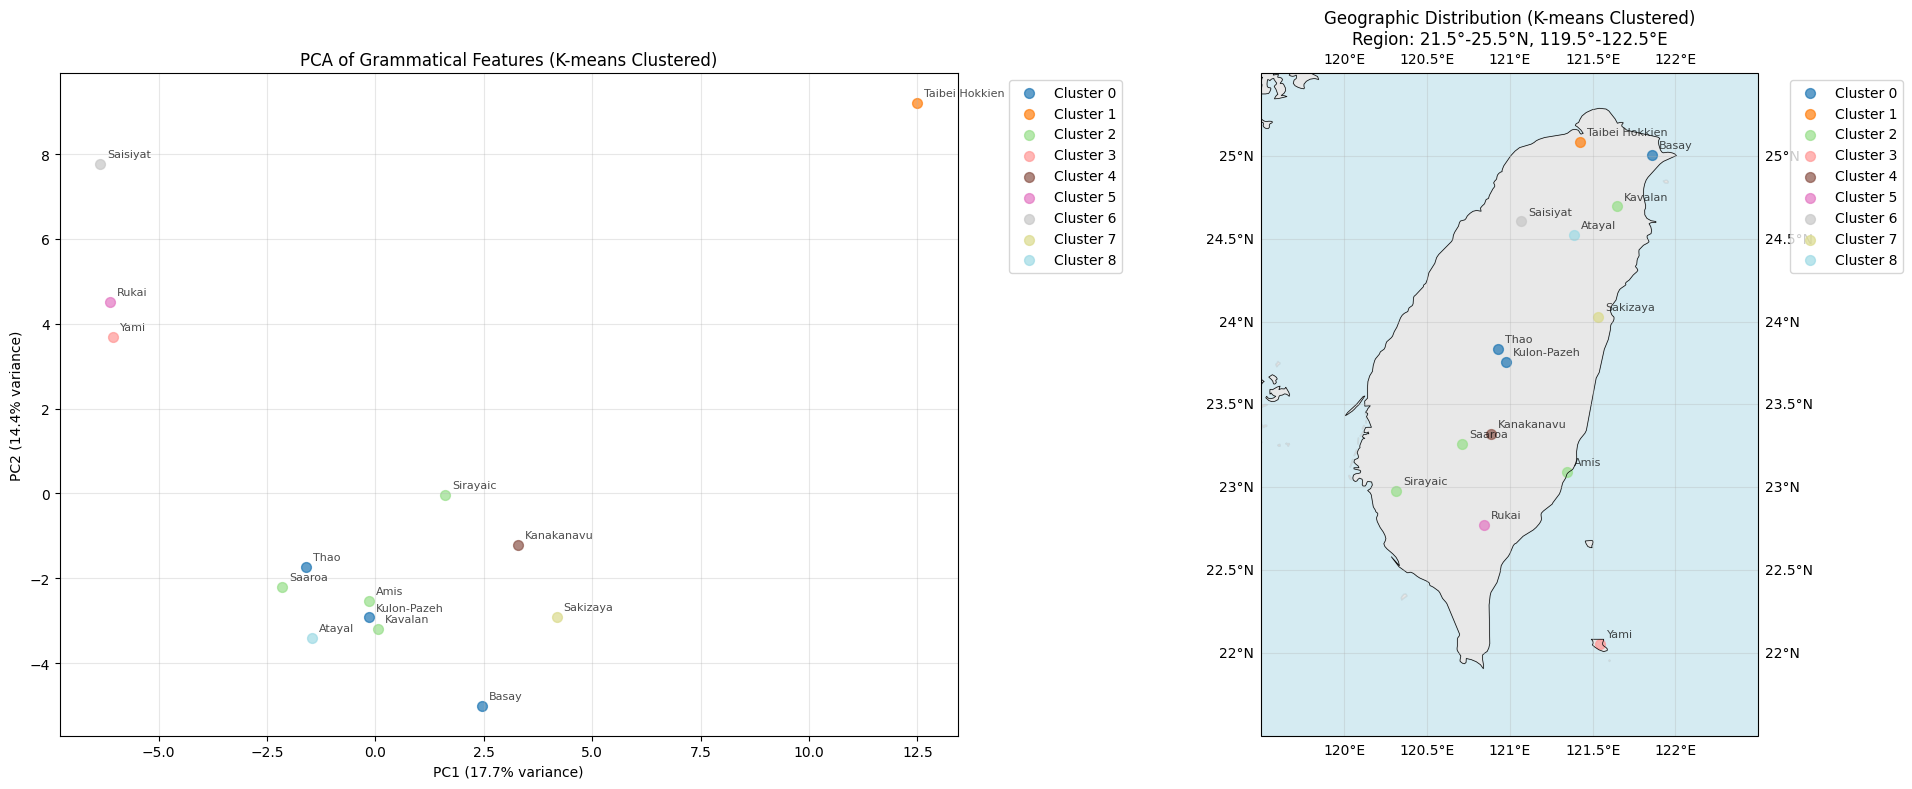

In [21]:
# Define your geographic region (lat/lon bounds)
lat_min, lat_max = 21.5, 25.5
lon_min, lon_max = 119.5, 122.5

# Filter languages by geographic coordinates
geo_languages = languages_df[
    (languages_df['Latitude'] >= lat_min) & 
    (languages_df['Latitude'] <= lat_max) & 
    (languages_df['Longitude'] >= lon_min) & 
    (languages_df['Longitude'] <= lon_max)
].copy()

# Get values for these languages
geo_values = values_df[values_df['Language_ID'].isin(geo_languages['ID'])].copy()

# Convert Value column to numeric, replacing non-numeric with NaN
geo_values['Value_numeric'] = pd.to_numeric(geo_values['Value'], errors='coerce')

# Filter for binary features only (0s and 1s)
binary_values = geo_values[geo_values['Value_numeric'].isin([0, 1])].copy()

# Create a pivot table: languages as rows, features as columns
feature_matrix = binary_values.pivot_table(
    index='Language_ID', 
    columns='Parameter_ID', 
    values='Value_numeric',
    fill_value=np.nan
)

# Drop languages/features with too many missing values
feature_matrix = feature_matrix.dropna(thresh=len(feature_matrix.columns)*0.5, axis=0)
feature_matrix = feature_matrix.dropna(thresh=len(feature_matrix.index)*0.5, axis=1)

# Fill remaining NaNs with 0 (assuming absence)
feature_matrix = feature_matrix.fillna(0)

# Create lang_coords for languages that are in our feature matrix
lang_coords = geo_languages[geo_languages['ID'].isin(feature_matrix.index)].copy()
lang_coords = lang_coords.set_index('ID').loc[feature_matrix.index].reset_index()

# Perform PCA
scaler = StandardScaler()
features_scaled = scaler.fit_transform(feature_matrix)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

# Perform K-means clustering
kmeans = KMeans(n_clusters=9, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# Get unique clusters and assign colors using a colormap that works well for many categories
unique_clusters = np.unique(clusters)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_clusters)))  # tab20 has 20 distinct colors
cluster_colors = {cluster: colors[i] for i, cluster in enumerate(unique_clusters)}

# Create subplot layout with cartopy projection
fig = plt.figure(figsize=(20, 8))

# Plot 1: PCA with clusters
ax1 = fig.add_subplot(1, 2, 1)
for cluster in unique_clusters:
    mask = clusters == cluster
    ax1.scatter(pca_result[mask, 0], pca_result[mask, 1], 
               c=[cluster_colors[cluster]], s=50, alpha=0.7, label=f'Cluster {cluster}')

for i, lang_id in enumerate(feature_matrix.index):
    lang_name = geo_languages[geo_languages['ID'] == lang_id]['Name'].iloc[0]
    ax1.annotate(lang_name, (pca_result[i, 0], pca_result[i, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax1.set_title('PCA of Grammatical Features (K-means Clustered)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Geographic plot with coastlines
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())

# Add map features
ax2.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax2.add_feature(cfeature.BORDERS, linewidth=0.5)
ax2.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.5)
ax2.add_feature(cfeature.LAND, color='lightgray', alpha=0.5)

# Add gridlines
ax2.gridlines(draw_labels=True, alpha=0.3)

# Plot language points
for cluster in unique_clusters:
    mask = clusters == cluster
    cluster_coords = lang_coords[mask]
    
    ax2.scatter(cluster_coords['Longitude'], cluster_coords['Latitude'], 
               c=[cluster_colors[cluster]], s=50, alpha=0.7, label=f'Cluster {cluster}',
               transform=ccrs.PlateCarree())

# Add language labels
for i, row in lang_coords.iterrows():
    ax2.annotate(row['Name'], (row['Longitude'], row['Latitude']), 
                xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7,
                transform=ccrs.PlateCarree())

# Set extent to your region
ax2.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

ax2.set_title(f'Geographic Distribution (K-means Clustered)\nRegion: {lat_min}°-{lat_max}°N, {lon_min}°-{lon_max}°E')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

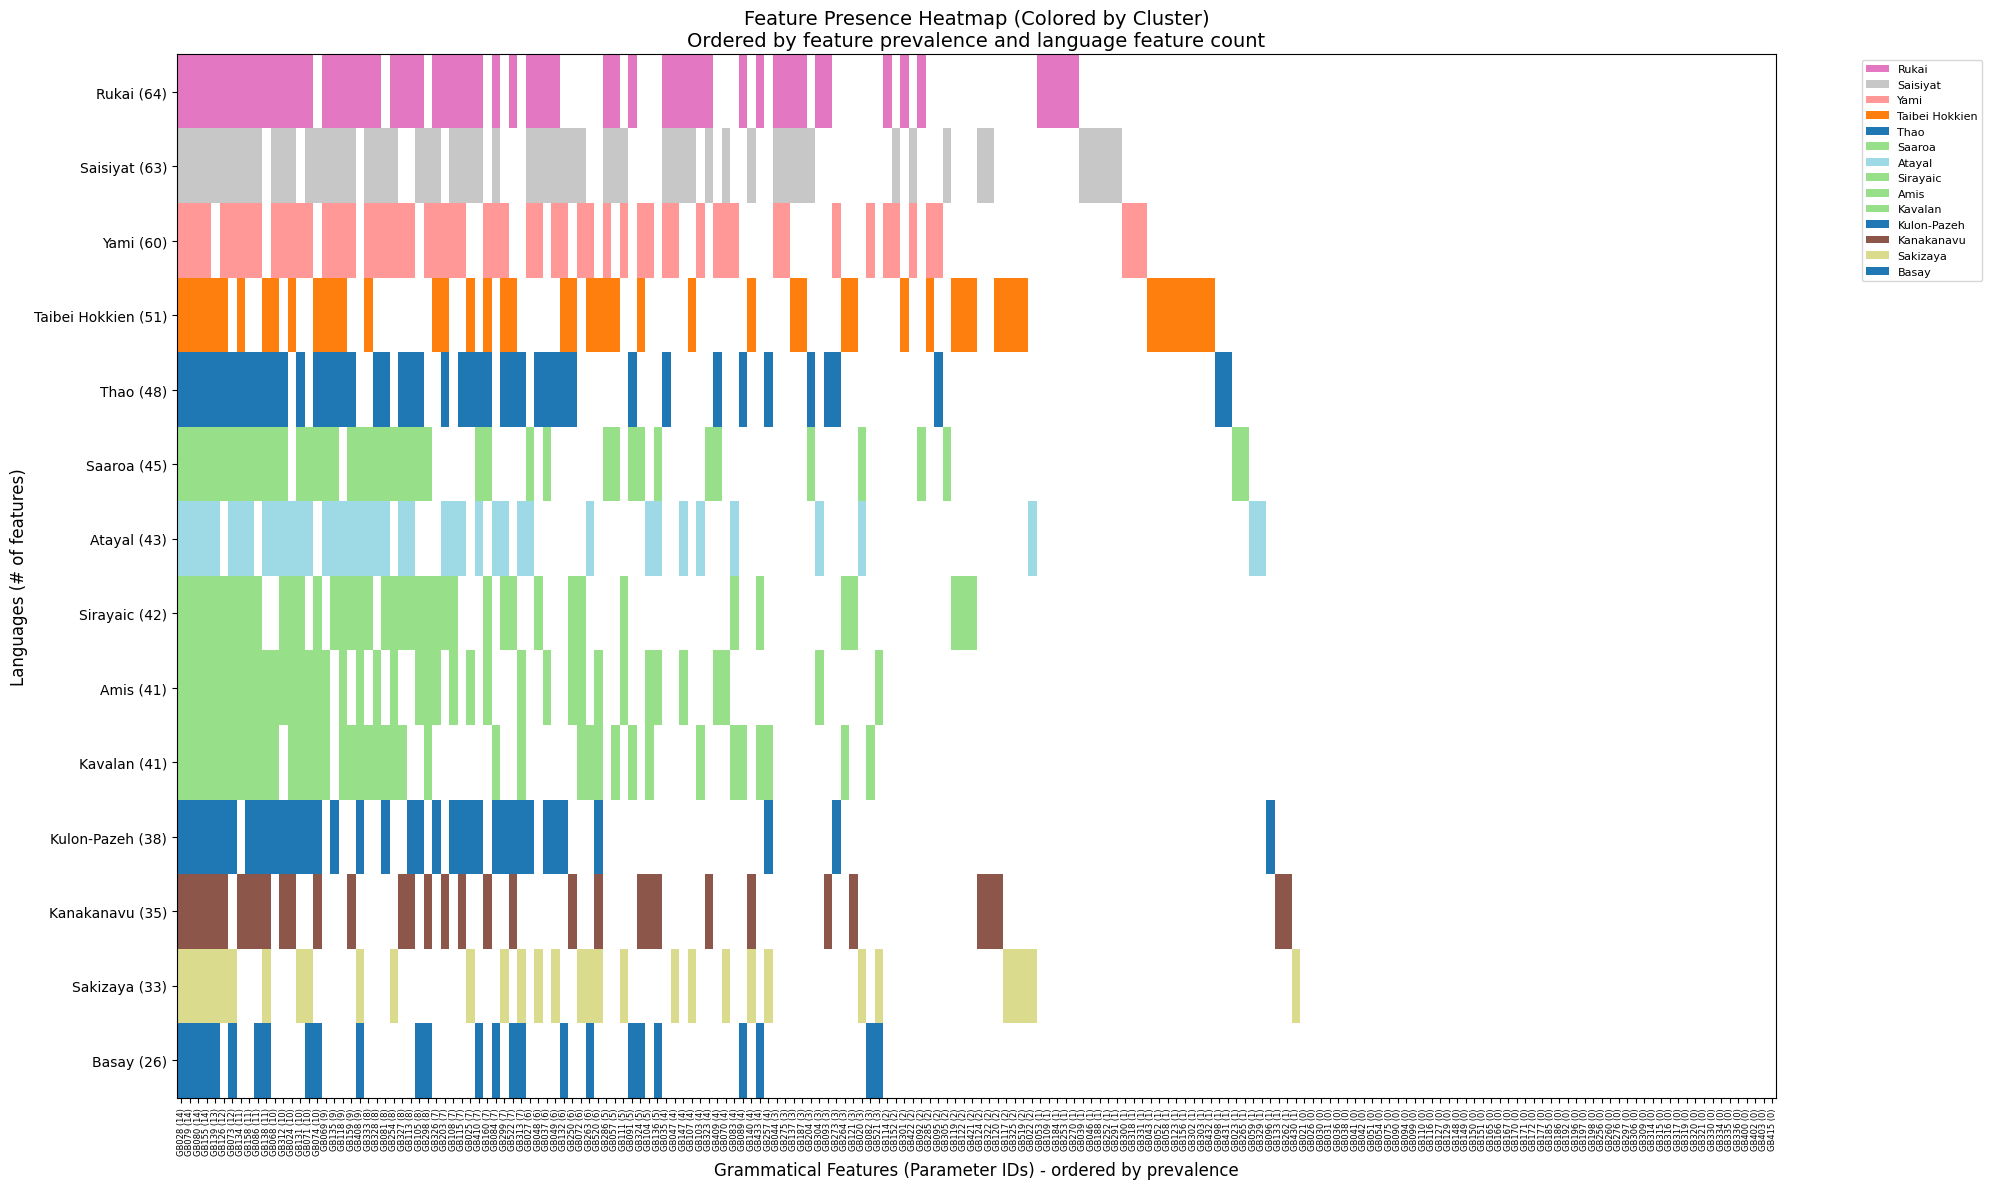

In [22]:
# Create heatmap of features by language, colored by cluster
# Get cluster colors for each language
original_indices = {lang_id: i for i, lang_id in enumerate(feature_matrix.index)}
cluster_color_map = {lang_id: cluster_colors[clusters[original_indices[lang_id]]] for lang_id in feature_matrix.index}

create_feature_heatmap(
    feature_matrix, 
    lang_coords, 
    cluster_color_map,
    'Feature Presence Heatmap (Colored by Cluster)\nOrdered by feature prevalence and language feature count'
)

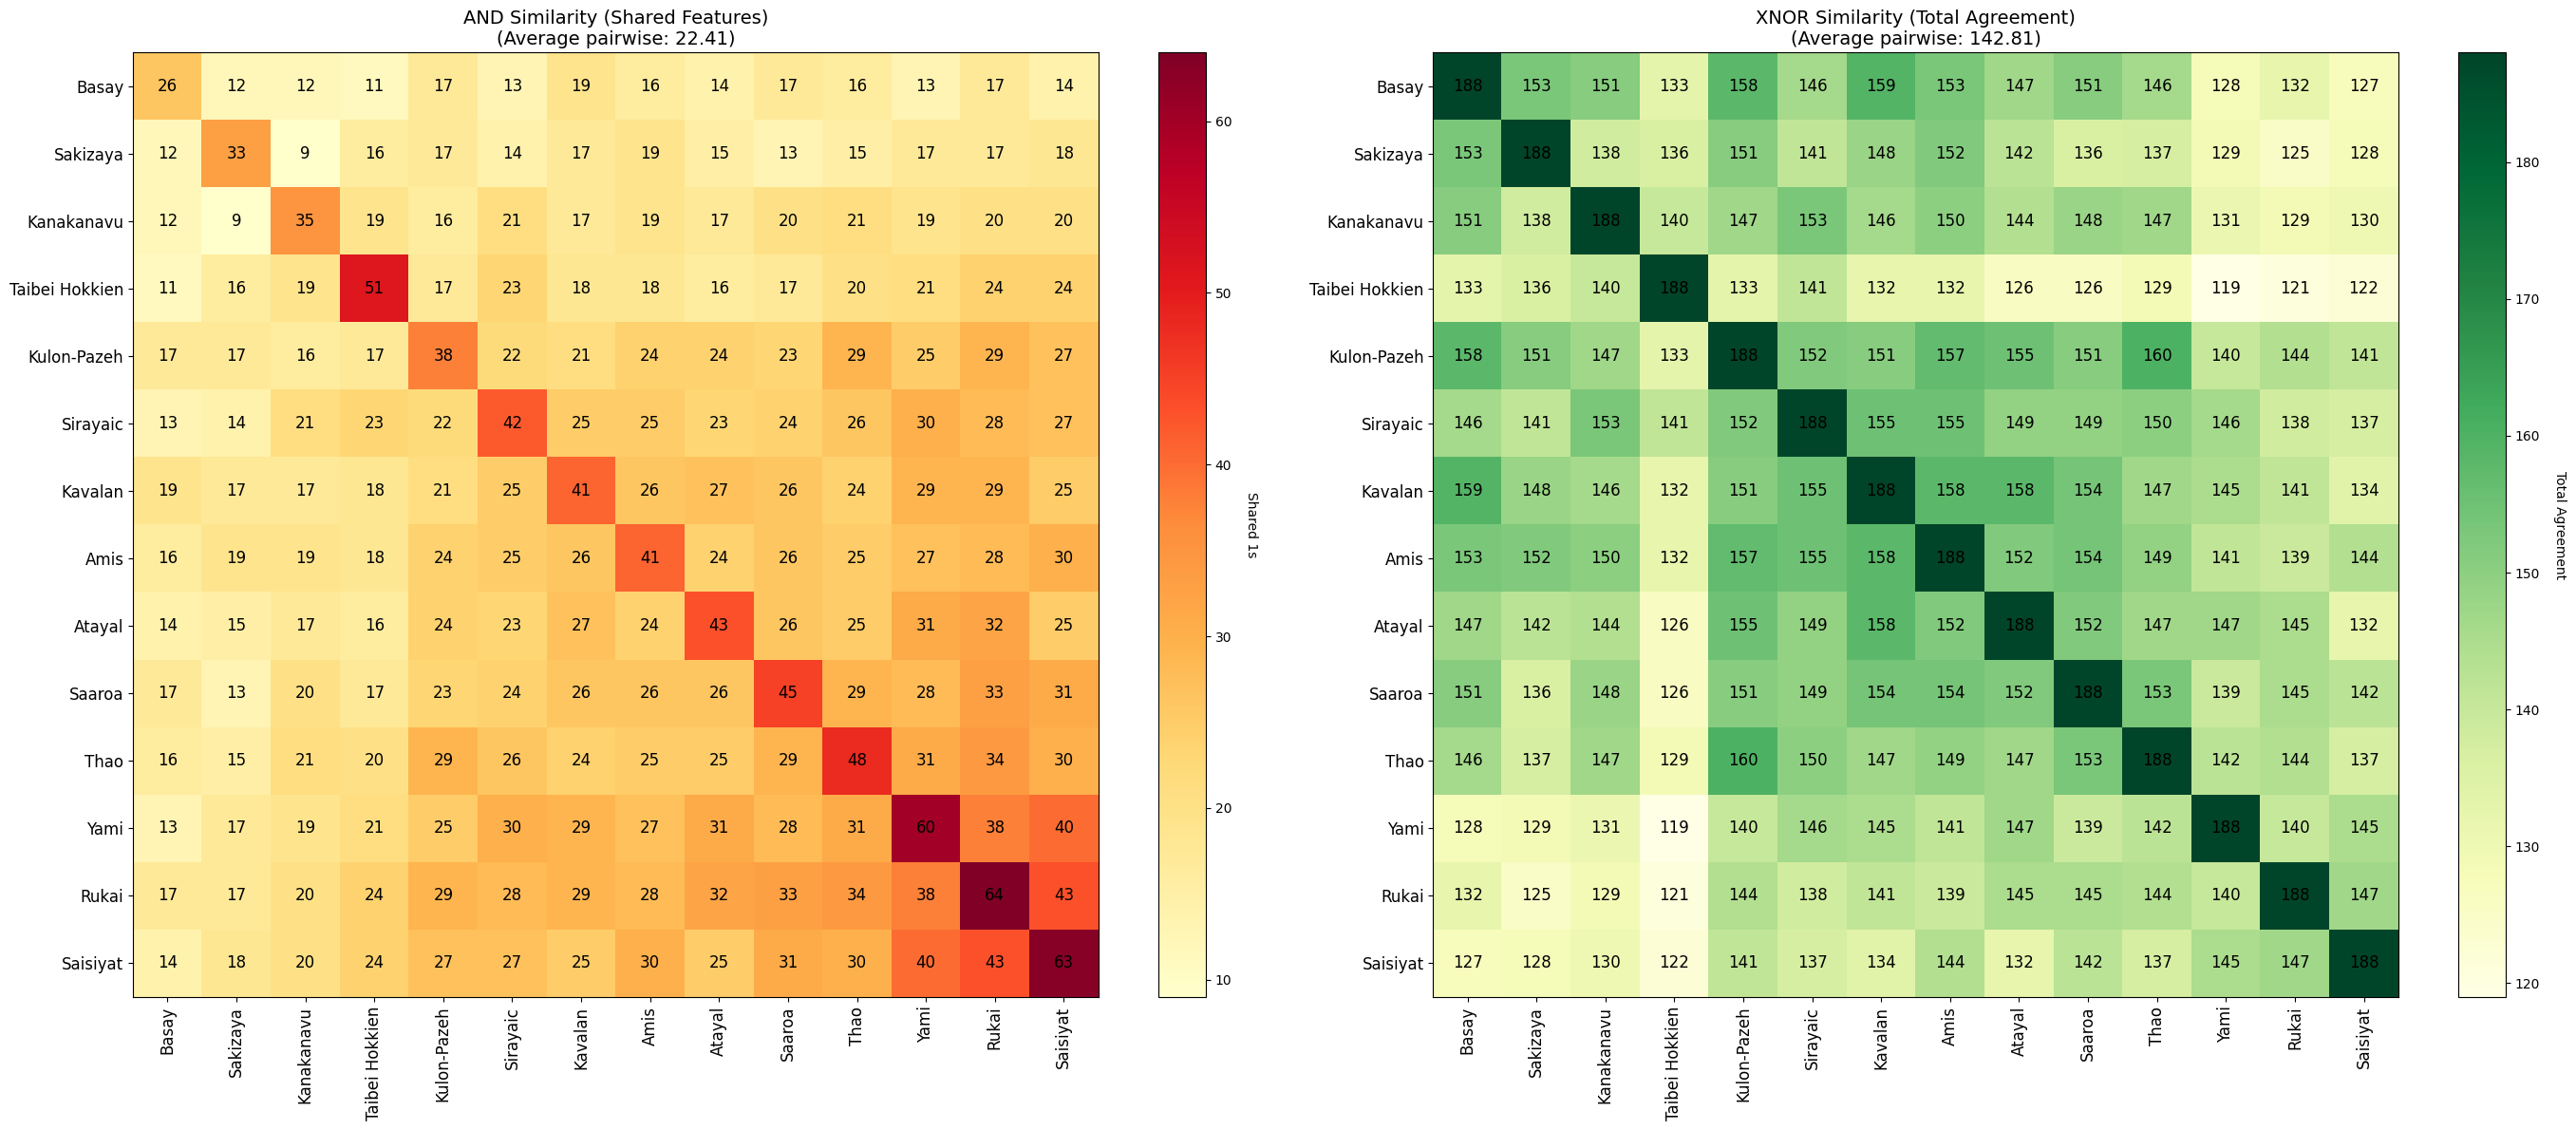

Total number of bits (features): 188
	AND Similarity (shared 1s):
		Average: 22.41, Min: 9, Max: 43
	XNOR Similarity (total agreement):
		Average: 142.81, Min: 119, Max: 160


In [23]:
# Calculate and visualize similarity matrices
and_matrix, xnor_matrix, n_features = calculate_similarity_matrices(feature_matrix)
lang_names = [lang_coords[lang_coords['Language_ID'] == lang_id]['Name'].iloc[0] for lang_id in feature_matrix.index]
visualize_similarity_matrices(and_matrix, xnor_matrix, lang_names)

Original: 14 languages, 188 features
Filtered: 13 languages, 124 features


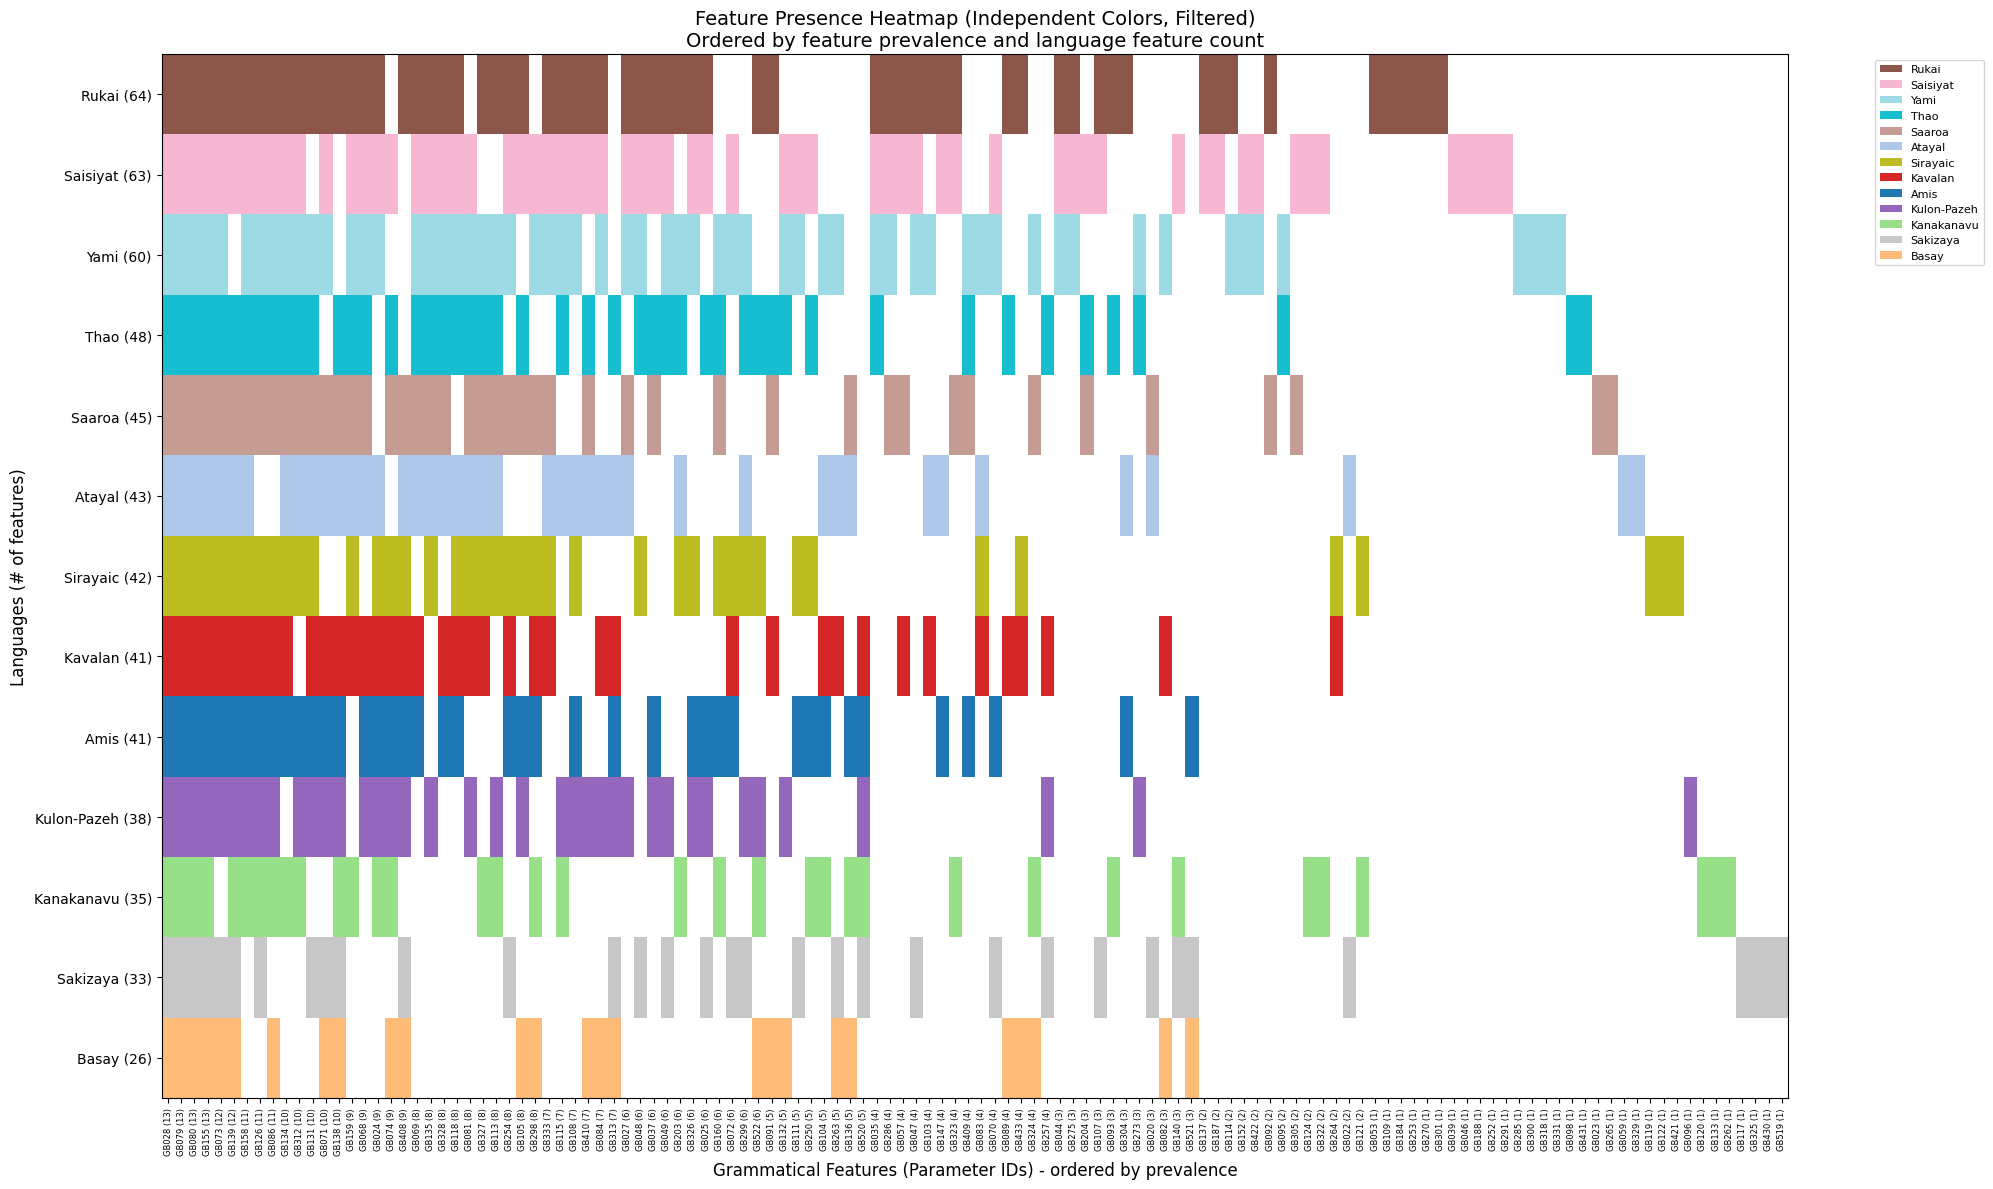

In [24]:
# Filter out Taibei Hokkien language
taibei_id = lang_coords[lang_coords['Name'] == 'Taibei Hokkien']['Language_ID'].values
if len(taibei_id) > 0:
    taibei_id = taibei_id[0]
    feature_matrix_filtered = feature_matrix[feature_matrix.index != taibei_id].copy()
    lang_coords_filtered = lang_coords[lang_coords['Language_ID'] != taibei_id].copy()
else:
    feature_matrix_filtered = feature_matrix.copy()
    lang_coords_filtered = lang_coords.copy()

# Remove features where all languages are 0
feature_sums = feature_matrix_filtered.sum(axis=0)
non_zero_features = feature_sums[feature_sums > 0].index
feature_matrix_filtered = feature_matrix_filtered[non_zero_features]

print(f"Original: {len(feature_matrix)} languages, {len(feature_matrix.columns)} features")
print(f"Filtered: {len(feature_matrix_filtered)} languages, {len(feature_matrix_filtered.columns)} features")

# Create heatmap with independent colors per language
n_langs_filtered = len(feature_matrix_filtered)
lang_colors = plt.cm.tab20(np.linspace(0, 1, n_langs_filtered))
lang_color_map = {lang_id: lang_colors[i] for i, lang_id in enumerate(feature_matrix_filtered.index)}

create_feature_heatmap(
    feature_matrix_filtered,
    lang_coords_filtered,
    lang_color_map,
    'Feature Presence Heatmap (Independent Colors, Filtered)\nOrdered by feature prevalence and language feature count'
)

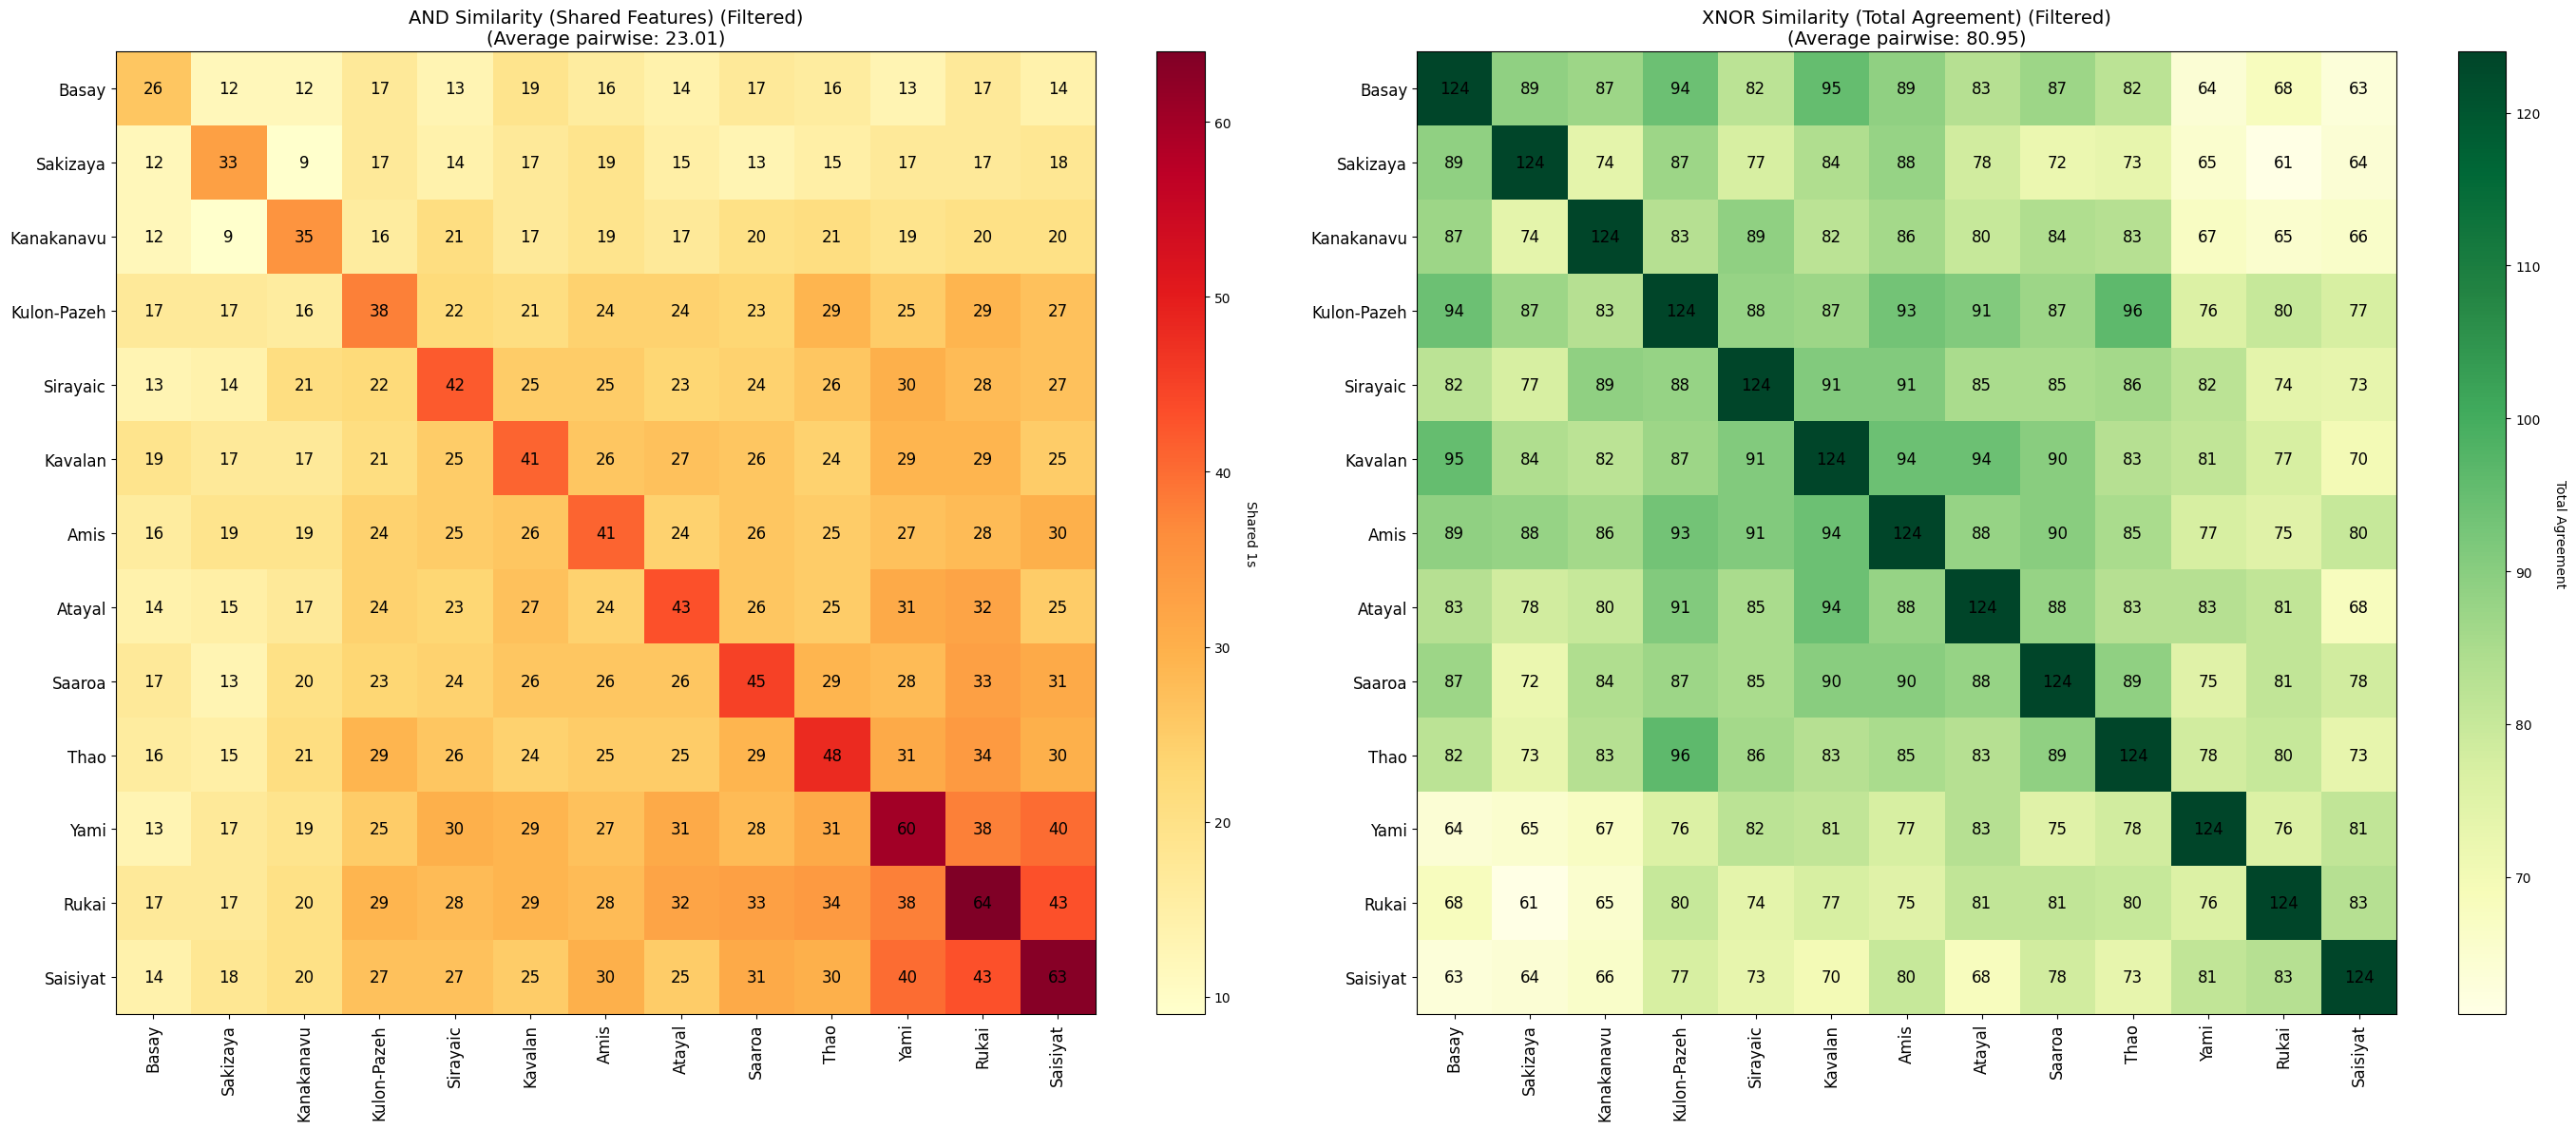

Total number of bits (features): 124
	AND Similarity (shared 1s):
		Average: 23.01, Min: 9, Max: 43
	XNOR Similarity (total agreement):
		Average: 80.95, Min: 61, Max: 96


In [25]:
# Calculate and visualize similarity matrices for filtered data
and_matrix, xnor_matrix, n_features = calculate_similarity_matrices(feature_matrix_filtered)
lang_names = [lang_coords_filtered[lang_coords_filtered['Language_ID'] == lang_id]['Name'].iloc[0] for lang_id in feature_matrix_filtered.index]
visualize_similarity_matrices(and_matrix, xnor_matrix, lang_names, title_suffix=" (Filtered)")

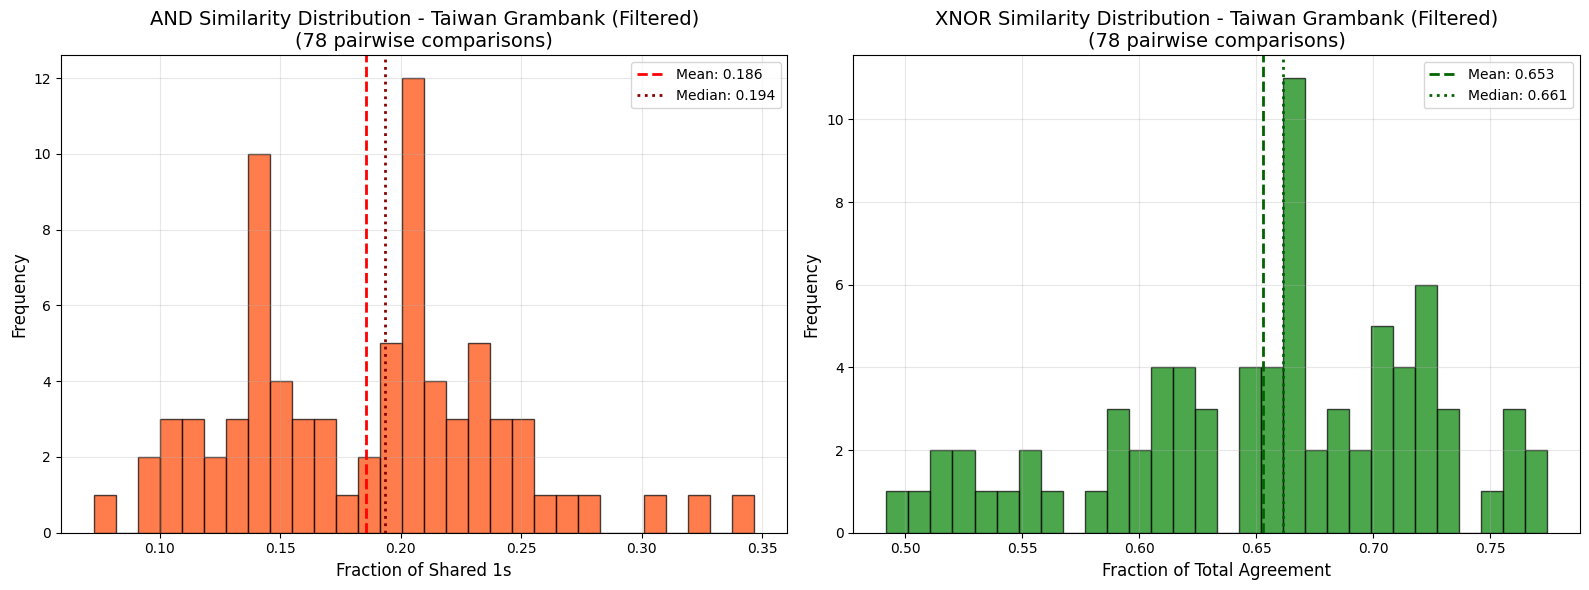

AND Similarity Statistics (normalized):
	Mean: 0.186, Median: 0.194
	Std Dev: 0.055, Min: 0.073, Max: 0.347

XNOR Similarity Statistics (normalized):
	Mean: 0.653, Median: 0.661
	Std Dev: 0.068, Min: 0.492, Max: 0.774
	(Based on 124 total features)


In [26]:
# Plot similarity distributions for filtered Taiwan Grambank data
plot_similarity_distributions(and_matrix, xnor_matrix, title_suffix=" - Taiwan Grambank (Filtered)")

Found file: /home/rizfn/github/babel-transition/src/paper_draft/2D/outputs/populationTimeseries/L_256_B_16/g_1_a_0.2_mu_1e-05.tsv
Timestep 20000: 27 total languages
Top 15 languages represent 63374 / 65536 = 96.7% of population


/tmp/ipykernel_1039/4241396680.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sort_keys = [(-feature_counts[i], -populations[i]) for i in range(len(sim_feature_matrix))]


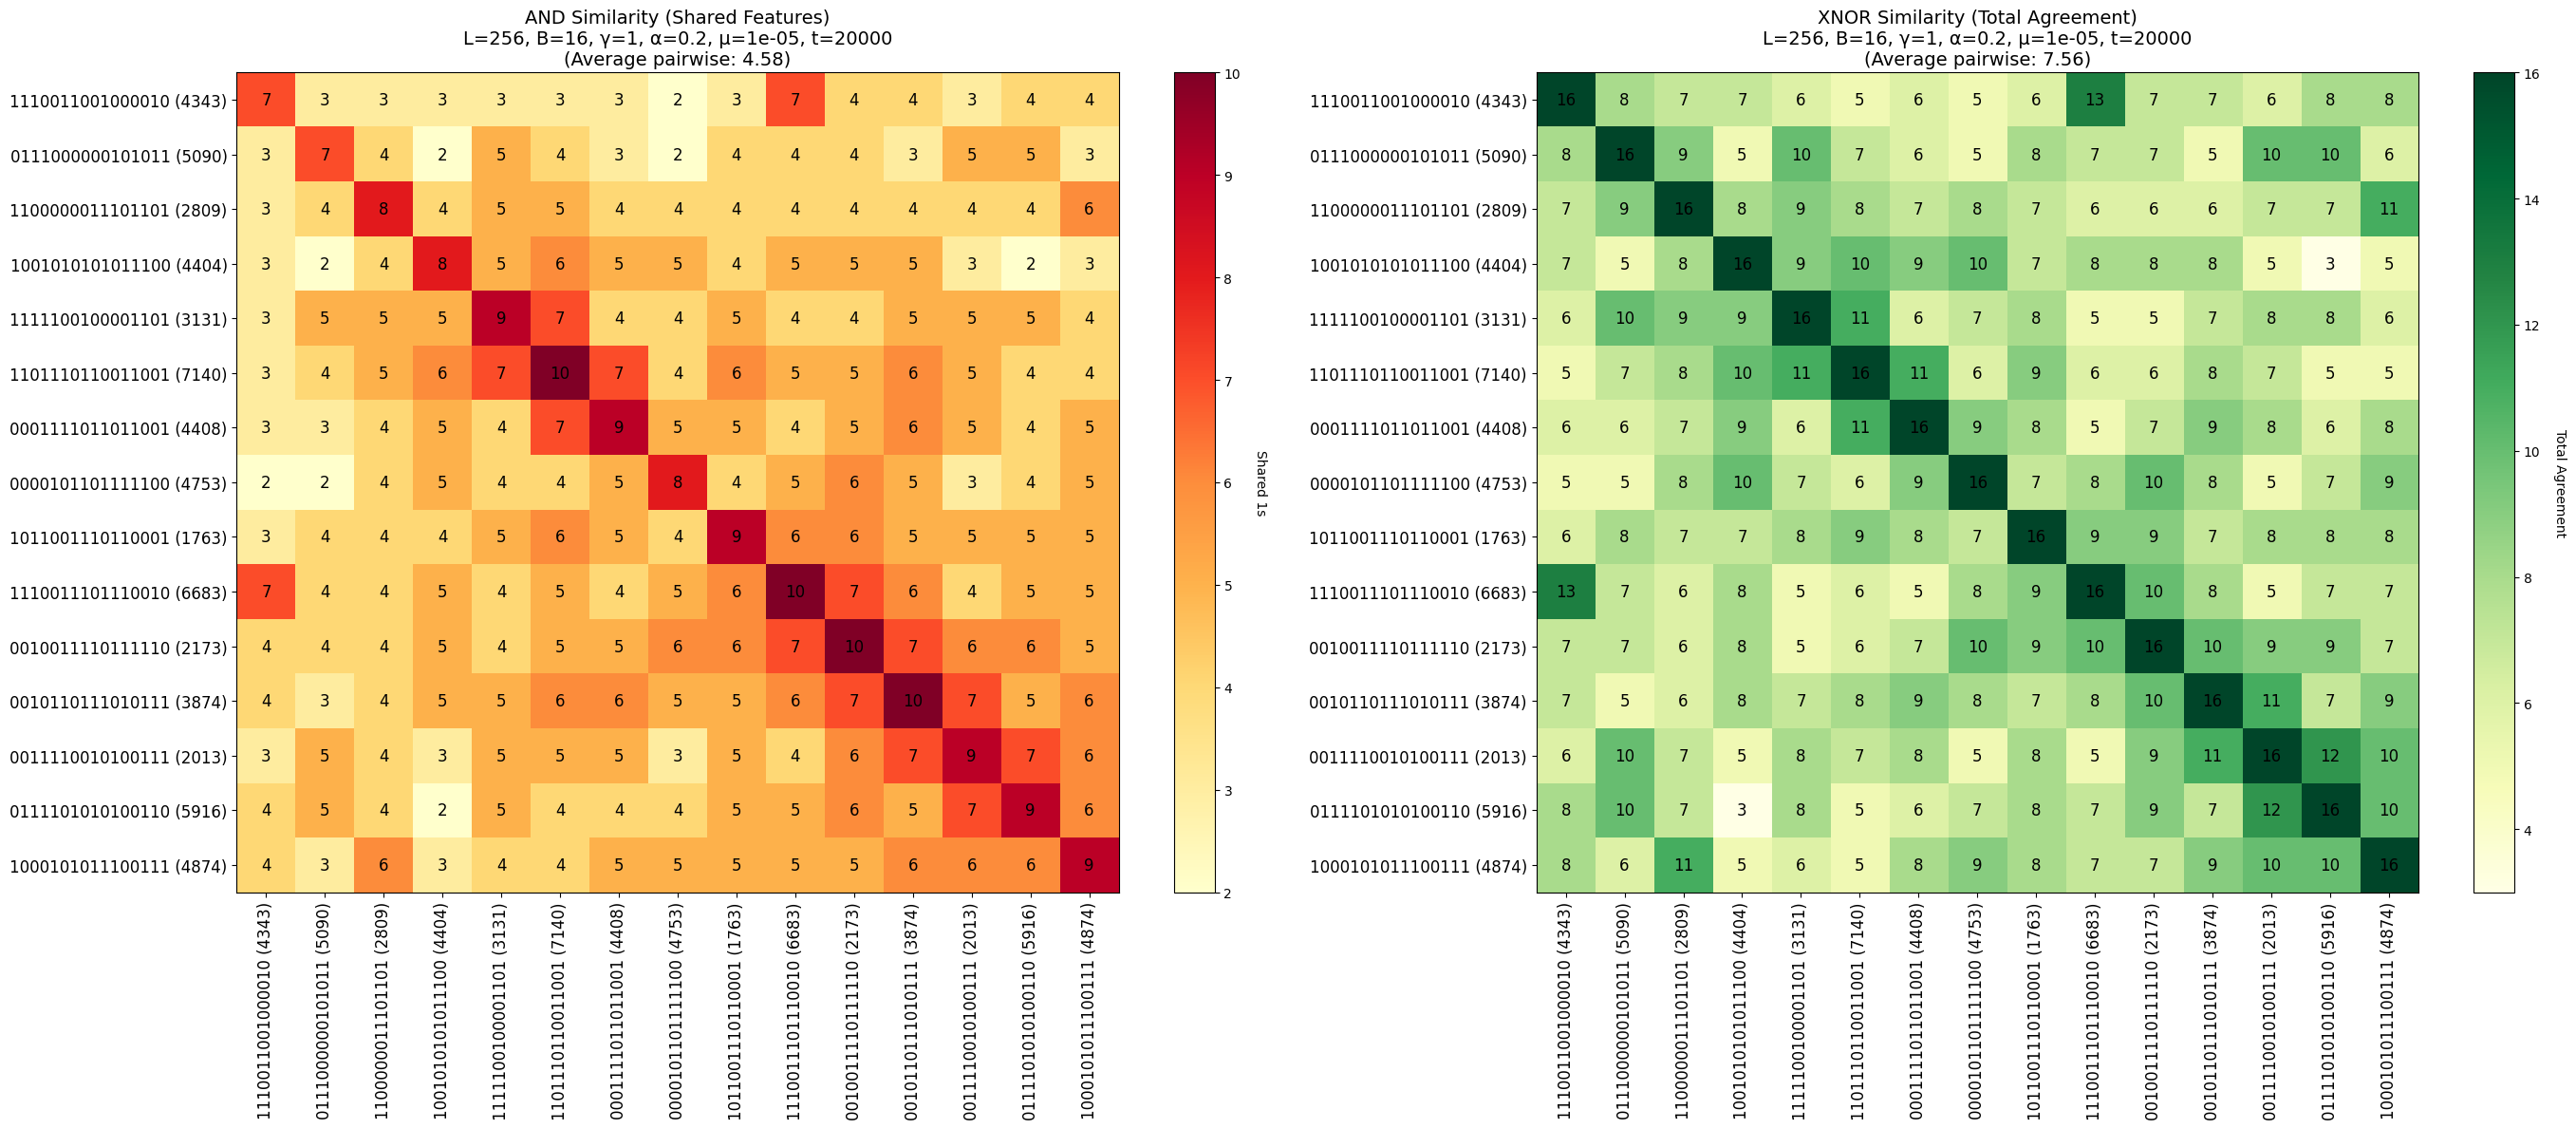

Total number of bits (features): 16
	AND Similarity (shared 1s):
		Average: 4.58, Min: 2, Max: 7
	XNOR Similarity (total agreement):
		Average: 7.56, Min: 3, Max: 13


In [54]:
# Parameters
L = 256
B = 16
gamma = 1
alpha = 0.2
mu = 1e-05
timestep = 20000
top_langs = 15

# Find and load the data file
def find_file_for_params(L, B, gamma, alpha, mu):
    """Find the file corresponding to given parameters."""
    base_path = "/home/rizfn/github/babel-transition/src"
    pattern = os.path.join(base_path, f"paper_draft/2D/outputs/populationTimeseries/L_{L}_B_{B}/g_{gamma}_a_{alpha}_mu_{mu}.tsv")
    if os.path.exists(pattern):
        return pattern
    
    # Try to find file with scientific notation for mu
    folder = os.path.join(base_path, f"paper_draft/2D/outputs/populationTimeseries/L_{L}_B_{B}")
    if not os.path.exists(folder):
        return None
    
    import re
    for fname in os.listdir(folder):
        if re.fullmatch(rf"g_{gamma}_a_{alpha}_mu_.*\.tsv", fname):
            mu_match = re.search(r'mu_([0-9eE\.\+-]+)', fname)
            if mu_match:
                mu_in_file = float(mu_match.group(1))
                if f"mu_{mu}" in fname or np.isclose(float(mu), mu_in_file, rtol=1e-8):
                    return os.path.join(folder, fname)
    return None

def parse_population_line(line):
    """Parse a single line from population timeseries format."""
    parts = line.strip().split('\t')
    if len(parts) < 2:
        return None, None
    
    step = int(parts[0])
    population_counts = {}
    
    for i in range(1, len(parts)):
        if ',' in parts[i]:
            bitstring, count_str = parts[i].split(',')
            population_counts[bitstring] = int(count_str)
    
    return step, population_counts

# Load data
filename = find_file_for_params(L, B, gamma, alpha, mu)
if filename is None:
    print(f"No file found for L={L}, B={B}, gamma={gamma}, alpha={alpha}, mu={mu}")
else:
    print(f"Found file: {filename}")
    
    # Read the specific timestep
    target_population = None
    with open(filename, "r") as f:
        for line in f:
            step, pop_counts = parse_population_line(line)
            if step == timestep:
                target_population = pop_counts
                break
    
    if target_population is None:
        print(f"Timestep {timestep} not found in file")
    else:
        # Get top languages by population
        sorted_langs = sorted(target_population.items(), key=lambda x: x[1], reverse=True)
        top_langs_list = sorted_langs[:top_langs]
        
        print(f"Timestep {timestep}: {len(target_population)} total languages")
        print(f"Top {top_langs} languages represent {sum(count for _, count in top_langs_list)} / {sum(target_population.values())} = {sum(count for _, count in top_langs_list)/sum(target_population.values()):.1%} of population")
        
        # Create feature matrix from bitstrings
        bitstrings = [lang for lang, _ in top_langs_list]
        populations = [count for _, count in top_langs_list]
        sim_feature_matrix = pd.DataFrame(
            [[int(bit) for bit in bitstring] for bitstring in bitstrings],
            index=[f"{bs} ({count})" for bs, count in top_langs_list]
        )
        
        # Order languages by feature count (number of 1s), then by population
        feature_counts = sim_feature_matrix.sum(axis=1)
        # Create sorting key: (-feature_count, -population) for descending order
        sort_keys = [(-feature_counts[i], -populations[i]) for i in range(len(sim_feature_matrix))]
        sorted_indices = sorted(range(len(sim_feature_matrix)), key=lambda i: sort_keys[i])
        
        # Reorder feature matrix
        sim_feature_matrix = sim_feature_matrix.iloc[sorted_indices]
        
        # Calculate and visualize similarity matrices
        and_matrix, xnor_matrix, n_features = calculate_similarity_matrices(sim_feature_matrix)
        lang_labels = list(sim_feature_matrix.index)
        
        title_suffix = f"\nL={L}, B={B}, γ={gamma}, α={alpha}, μ={mu}, t={timestep}"
        # Use proxy labels if B > 16
        visualize_similarity_matrices(and_matrix, xnor_matrix, lang_labels, title_suffix=title_suffix, figsize=(28, 12), use_proxy_labels=(B > 16))

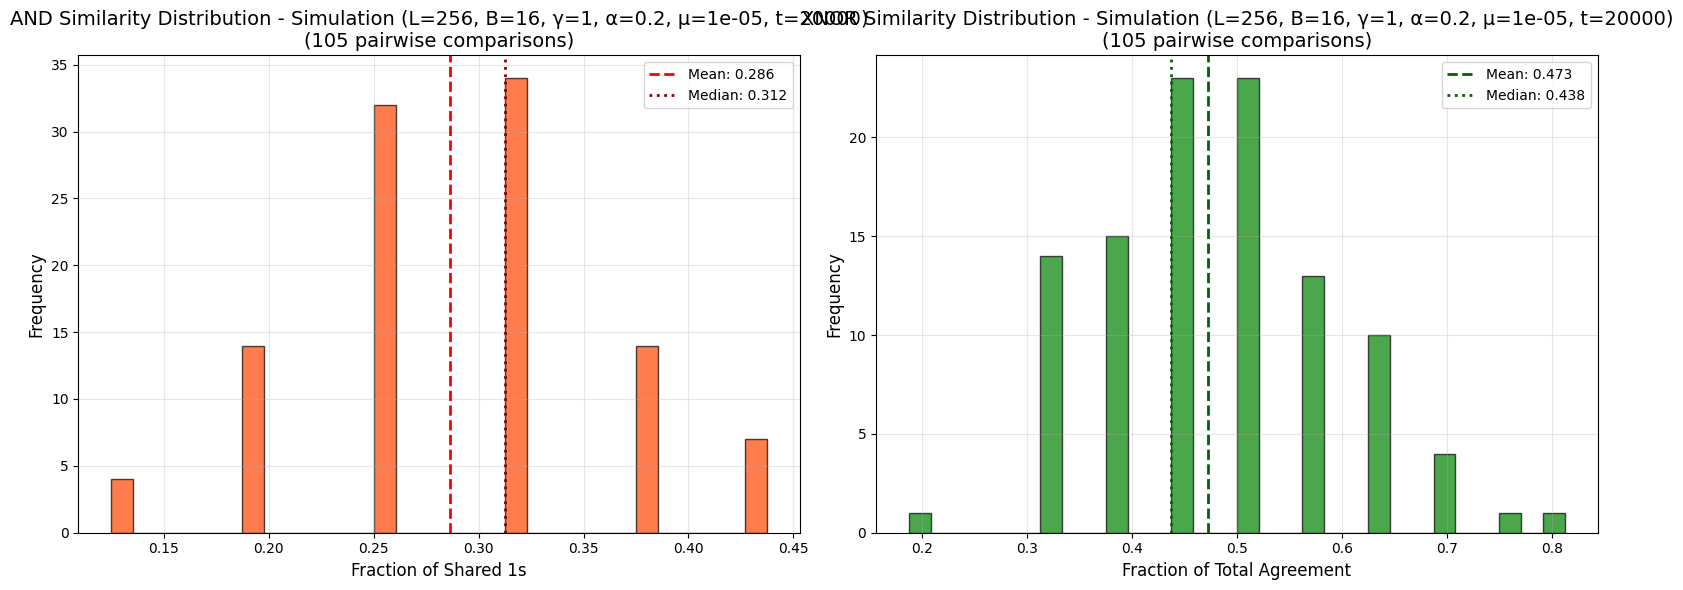

AND Similarity Statistics (normalized):
	Mean: 0.286, Median: 0.312
	Std Dev: 0.074, Min: 0.125, Max: 0.438

XNOR Similarity Statistics (normalized):
	Mean: 0.473, Median: 0.438
	Std Dev: 0.113, Min: 0.188, Max: 0.812
	(Based on 16 total features)


In [28]:
# Plot similarity distributions for simulation data
if 'and_matrix' in locals() and 'xnor_matrix' in locals():
    title_suffix = f" - Simulation (L={L}, B={B}, γ={gamma}, α={alpha}, μ={mu}, t={timestep})"
    plot_similarity_distributions(and_matrix, xnor_matrix, title_suffix=title_suffix)

/tmp/ipykernel_1039/868162775.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sort_keys = [(sim_feature_counts[i], -populations[i]) for i in range(len(sim_feature_matrix))]


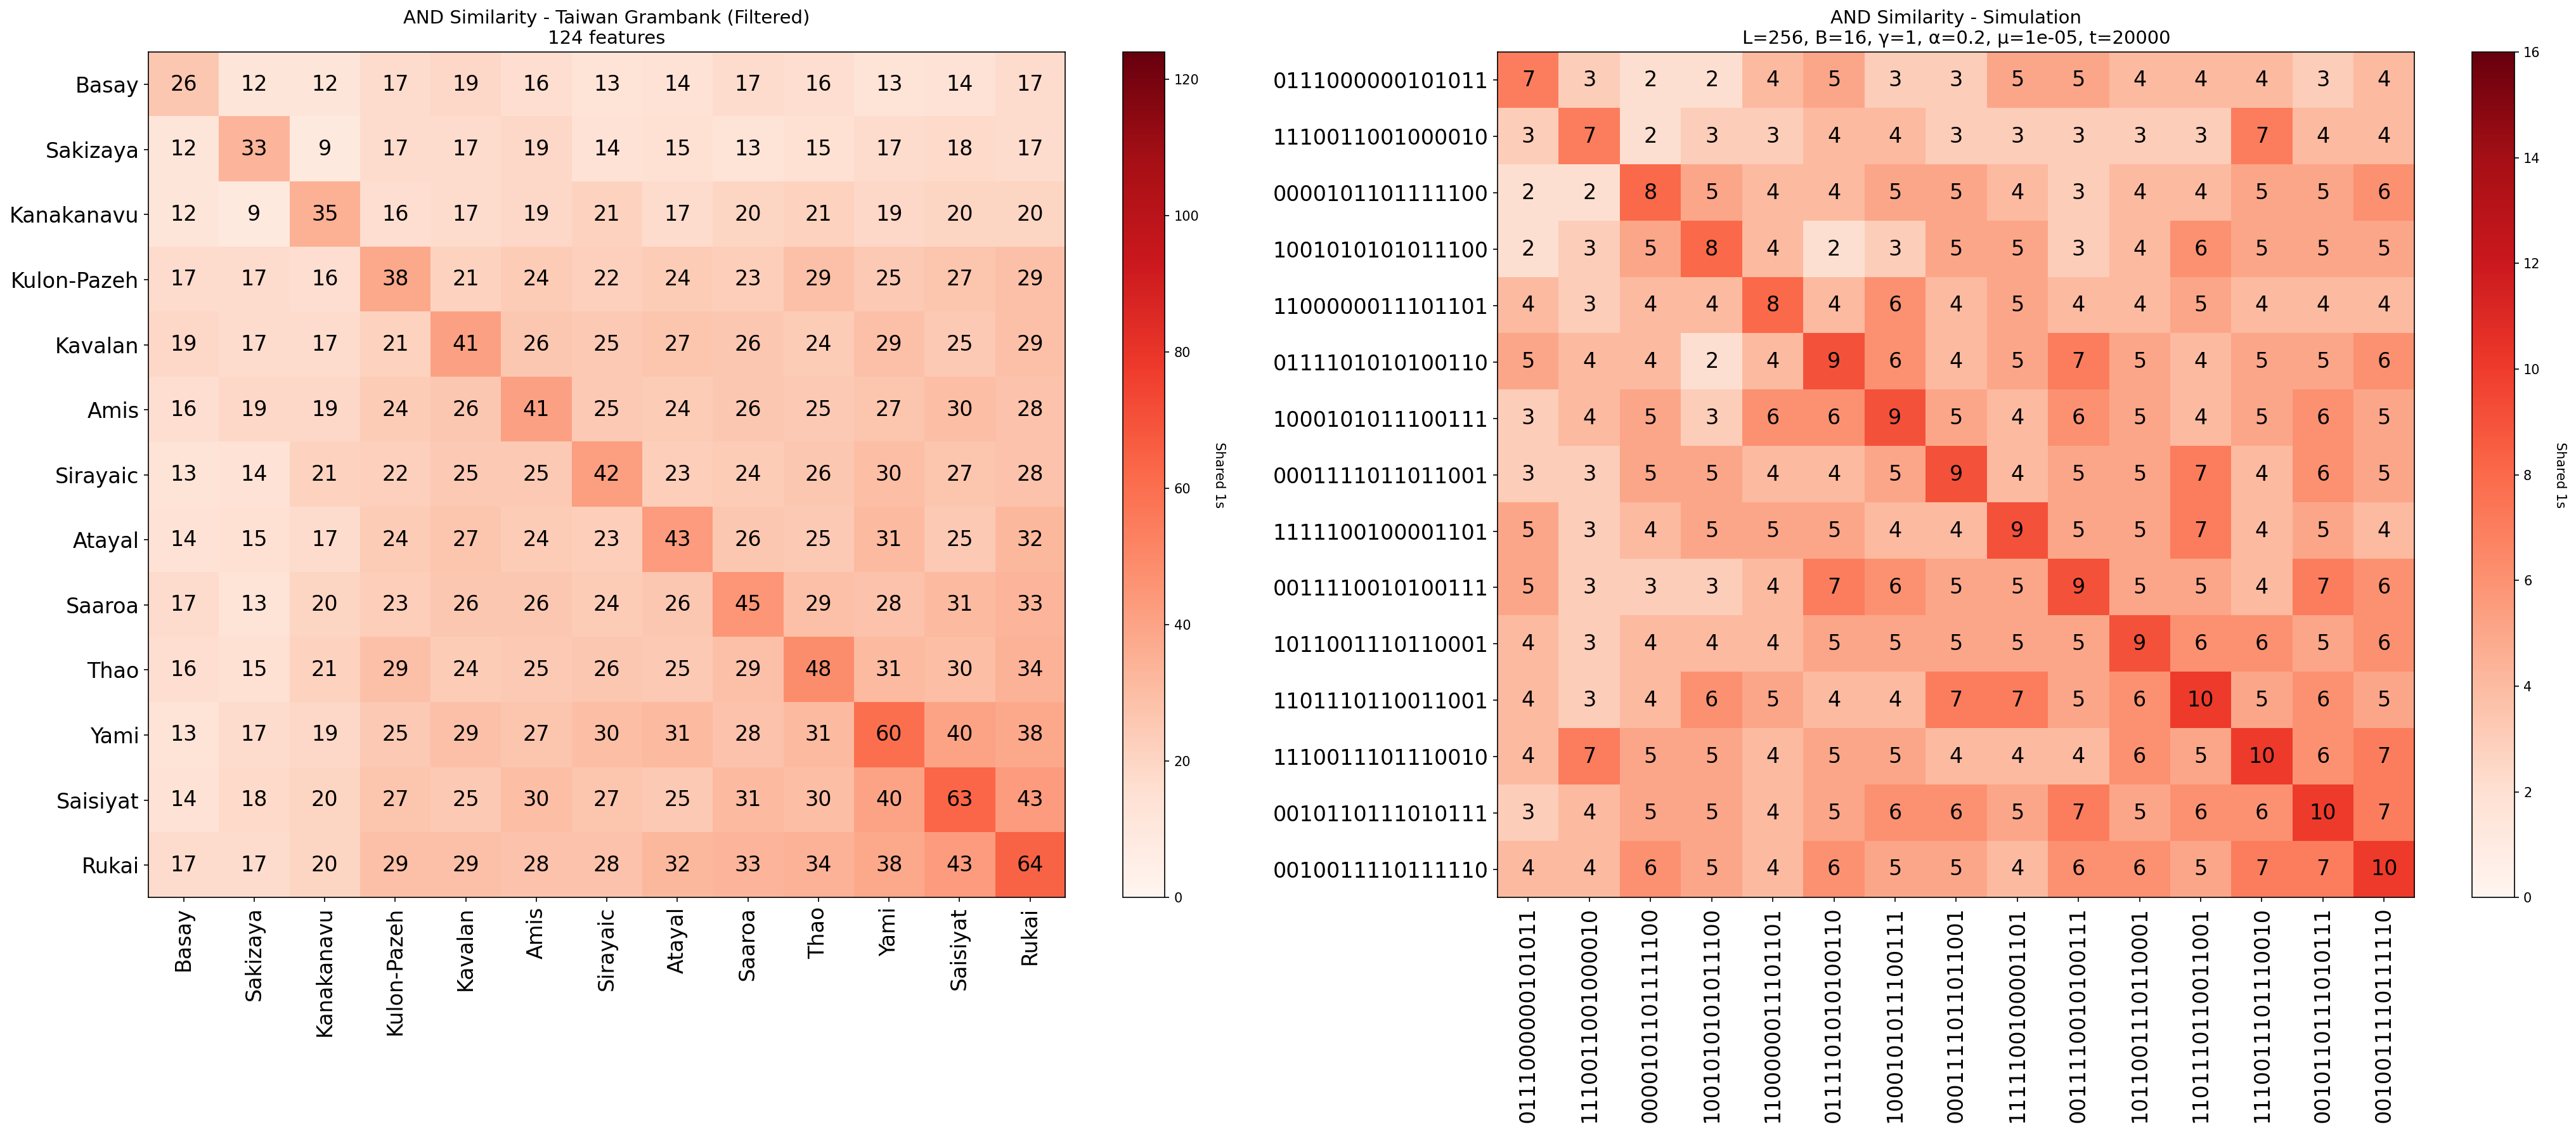

Saved comparison plot to /home/rizfn/github/babel-transition/src/dataAnalysis/grambank/plots/and_similarity_comparison.svg


In [ ]:
# Save XOR (AND) similarity matrices as SVG with transparent background
import os

# Font size parameters (adjust these as needed)
label_fontsize = 16
cell_text_fontsize = 16
title_fontsize = 14


# Create plots directory if it doesn't exist
plots_dir = "/home/rizfn/github/babel-transition/src/dataAnalysis/grambank/plots"
os.makedirs(plots_dir, exist_ok=True)

# We need to recalculate the Taiwan filtered matrices since they were overwritten
and_matrix_taiwan_full, xnor_matrix_taiwan_full, n_features_taiwan = calculate_similarity_matrices(feature_matrix_filtered)

# Order Taiwan languages by feature count (ascending - few 1s first)
taiwan_feature_counts = feature_matrix_filtered.sum(axis=1)
taiwan_sorted_indices = taiwan_feature_counts.sort_values().index
and_matrix_taiwan = and_matrix_taiwan_full[list(range(len(taiwan_sorted_indices))), :][:, list(range(len(taiwan_sorted_indices)))]
# Reorder matrix properly
taiwan_idx_map = {lang_id: i for i, lang_id in enumerate(feature_matrix_filtered.index)}
taiwan_sorted_idx = [taiwan_idx_map[lang_id] for lang_id in taiwan_sorted_indices]
and_matrix_taiwan = and_matrix_taiwan_full[taiwan_sorted_idx, :][:, taiwan_sorted_idx]
lang_names_taiwan = [lang_coords_filtered[lang_coords_filtered['Language_ID'] == lang_id]['Name'].iloc[0] 
                     for lang_id in taiwan_sorted_indices]

# Reload simulation data
filename = find_file_for_params(L, B, gamma, alpha, mu)
with open(filename, "r") as f:
    for line in f:
        step, pop_counts = parse_population_line(line)
        if step == timestep:
            target_population = pop_counts
            break

sorted_langs = sorted(target_population.items(), key=lambda x: x[1], reverse=True)
top_langs_list = sorted_langs[:top_langs]

# Create feature matrix from bitstrings
bitstrings = [lang for lang, _ in top_langs_list]
populations = [count for _, count in top_langs_list]
sim_feature_matrix = pd.DataFrame(
    [[int(bit) for bit in bitstring] for bitstring in bitstrings],
    index=[bs for bs, count in top_langs_list]
)

# Order simulation languages by feature count (ascending - few 1s first), then by population
sim_feature_counts = sim_feature_matrix.sum(axis=1)
sort_keys = [(sim_feature_counts[i], -populations[i]) for i in range(len(sim_feature_matrix))]
sim_sorted_indices = sorted(range(len(sim_feature_matrix)), key=lambda i: sort_keys[i])
sim_feature_matrix = sim_feature_matrix.iloc[sim_sorted_indices]

# Calculate similarity matrices for simulation
and_matrix_sim, xnor_matrix_sim, n_features_sim = calculate_similarity_matrices(sim_feature_matrix)
lang_labels_sim = list(sim_feature_matrix.index)

# Create side-by-side comparison plot
n_langs_taiwan = len(and_matrix_taiwan)
n_langs_sim = len(and_matrix_sim)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 12), dpi=150)
fig.patch.set_alpha(0)

# Plot 1: Taiwan filtered data
ax1.patch.set_alpha(0)
im1 = ax1.imshow(and_matrix_taiwan, cmap='Reds', aspect='auto', vmin=0, vmax=n_features_taiwan)
cbar1 = plt.colorbar(im1, ax=ax1)
cbar1.set_label('Shared 1s', rotation=270, labelpad=20, fontsize=label_fontsize)
cbar1.ax.tick_params(labelsize=label_fontsize)

ax1.set_xticks(range(n_langs_taiwan))
ax1.set_yticks(range(n_langs_taiwan))
ax1.set_xticklabels(lang_names_taiwan, rotation=90, fontsize=label_fontsize)
ax1.set_yticklabels(lang_names_taiwan, fontsize=label_fontsize)

# Add numbers inside heatmap
for i in range(n_langs_taiwan):
    for j in range(n_langs_taiwan):
        ax1.text(j, i, f'{int(and_matrix_taiwan[i, j])}',
                ha="center", va="center", color="black", fontsize=cell_text_fontsize)

ax1.set_title(f'AND Similarity - Taiwan Grambank (Filtered)\n{n_features_taiwan} features', fontsize=title_fontsize)

# Plot 2: Simulation data
ax2.patch.set_alpha(0)
im2 = ax2.imshow(and_matrix_sim, cmap='Reds', aspect='auto', vmin=0, vmax=n_features_sim)
cbar2 = plt.colorbar(im2, ax=ax2)
cbar2.set_label('Shared 1s', rotation=270, labelpad=20, fontsize=label_fontsize)
cbar2.ax.tick_params(labelsize=label_fontsize)

ax2.set_xticks(range(n_langs_sim))
ax2.set_yticks(range(n_langs_sim))
ax2.set_xticklabels(lang_labels_sim, rotation=90, fontsize=label_fontsize)
ax2.set_yticklabels(lang_labels_sim, fontsize=label_fontsize)

# Add numbers inside heatmap
for i in range(n_langs_sim):
    for j in range(n_langs_sim):
        ax2.text(j, i, f'{int(and_matrix_sim[i, j])}',
                ha="center", va="center", color="black", fontsize=cell_text_fontsize)

ax2.set_title(f'AND Similarity - Simulation\nL={L}, B={B}, γ={gamma}, α={alpha}, μ={mu}, t={timestep}', fontsize=title_fontsize)

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'and_similarity_comparison.svg'), 
            format='svg', transparent=True, bbox_inches='tight')
plt.show()
print(f"Saved comparison plot to {os.path.join(plots_dir, 'and_similarity_comparison.svg')}")
